In [1]:
import torch
from torchvision import datasets, transforms, models
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pathlib import Path
import importlib
import models.resnet50_scratch_dag as mod

In [2]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
transform_train=transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.RandomRotation(10),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))
                                   ])
transform=transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.RandomRotation(10),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))
                             ])
training_dataset=datasets.ImageFolder('D:/Data/faceImage/train', transform=transform_train)
validation_dataset=datasets.ImageFolder('D:/Data/faceImage/val', transform=transform)
training_loader=torch.utils.data.DataLoader(training_dataset, batch_size=4, shuffle=True)
validation_loader=torch.utils.data.DataLoader(validation_dataset, batch_size=4, shuffle=False)

In [4]:
print(len(training_dataset))
len(validation_dataset)

35


8

In [5]:
def im_convert(tensor):
    image=tensor.clone().detach().numpy() #first dim= color, second= width, third =height
    image= image.transpose(1, 2, 0) #swap axis 0 to 1 and 1 to 2 and 2 to 0
#normalizaion = Z= (x-mean)/SD. So, we do this:

    image =image*np.array((0.5, 0.5, 0.5))+ np.array((0.5, 0.5, 0.5))
    image=image.clip(0, 1) #to ensure the values are in betn 0 and 1
    return image

In [6]:
classes=['Channing', 'Pruthvi']#order  is important. ant- class1 bees- class2

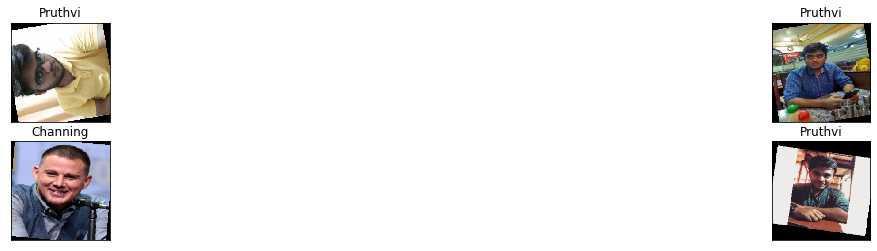

In [7]:
dataiter = iter(training_loader)
images, labels = dataiter.next()#grabs first batch of training data
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(4):
    ax = fig.add_subplot(2, 2, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))#2 rows and 10 cols and index
    ax.set_title(classes[labels[idx].item()])

In [8]:
name='resnet50_scratch_dag'
module_ = mod
model_factory = getattr(module_, name)

model=model_factory('models/resnet50_scratch_dag.pth')

In [9]:
# mod=models.vgg16(pretrained=True)
# n_inputs=mod.classifier[6].in_features #here, 4096 inputs recieved  in this layer this can be put into new layer
# last_layer=nn.Linear(n_inputs, len(classes))
# mod.classifier[6]=last_layer
# model.classifier=mod
model=model.to(device)
model

Resnet50_scratch_dag(
  (conv1_7x7_s2): Conv2d(3, 64, kernel_size=[7, 7], stride=(2, 2), padding=(3, 3), bias=False)
  (conv1_7x7_s2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_relu_7x7_s2): ReLU()
  (pool1_3x3_s2): MaxPool2d(kernel_size=[3, 3], stride=[2, 2], padding=(0, 0), dilation=1, ceil_mode=True)
  (conv2_1_1x1_reduce): Conv2d(64, 64, kernel_size=[1, 1], stride=(1, 1), bias=False)
  (conv2_1_1x1_reduce_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1_1x1_reduce_relu): ReLU()
  (conv2_1_3x3): Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
  (conv2_1_3x3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1_3x3_relu): ReLU()
  (conv2_1_1x1_increase): Conv2d(64, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
  (conv2_1_1x1_increase_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [10]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.0009)

In [31]:
epochs=50
running_loss_history=[]
running_corrects_history=[]
val_running_loss_history=[]
val_running_corrects_history=[]

for e in range(epochs):
    running_loss=0.0
    running_corrects=0.0
    val_running_loss=0.0
    val_running_corrects=0.0
    
    for inputs, labels in training_loader:
        inputs=inputs.to(device)
        labels=labels.to(device)
        
        outputs, hidden = model(inputs)
#         outputs=model(inputs)
        loss=criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds=torch.max(outputs, 1)
        running_loss+=loss.item()
        running_corrects+=torch.sum(preds==labels.data)
        
    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs=val_inputs.to(device)
                val_labels=val_labels.to(device)
                
                val_outputs, hidden=model(val_inputs)
                val_loss=criterion(val_outputs, val_labels)
                
                _, val_preds=torch.max(val_outputs, 1)
                val_running_loss+=val_loss.item()
                val_running_corrects+=torch.sum(val_preds==val_labels.data)
        
        epoch_loss=(running_loss)/len(training_loader.dataset)
        epoch_acc= (running_corrects.float())/len(training_loader.dataset)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        print("EPOCH: ", e+1)
        print('training loss: {:.4f}, Train Accuracy {:.4f}'.format(epoch_loss, epoch_acc.item()))
        
        val_epoch_loss=(val_running_loss)/len(validation_loader.dataset)
        val_epoch_acc= (val_running_corrects.float())/len(validation_loader.dataset)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)

        print('Validation loss: {:.4f}, Validation Accuracy {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

EPOCH:  1
training loss: 0.1263, Train Accuracy 0.7714
Validation loss: 0.3006, Validation Accuracy 0.7500
EPOCH:  2
training loss: 0.1609, Train Accuracy 0.8000
Validation loss: 0.3480, Validation Accuracy 0.6250
EPOCH:  3
training loss: 0.2013, Train Accuracy 0.6571
Validation loss: 0.2549, Validation Accuracy 0.5000
EPOCH:  4
training loss: 0.1372, Train Accuracy 0.7143
Validation loss: 0.2778, Validation Accuracy 0.5000
EPOCH:  5
training loss: 0.1673, Train Accuracy 0.5714
Validation loss: 0.2168, Validation Accuracy 0.5000
EPOCH:  6
training loss: 0.0938, Train Accuracy 0.8571
Validation loss: 0.2151, Validation Accuracy 0.5000
EPOCH:  7
training loss: 0.1271, Train Accuracy 0.7143
Validation loss: 0.2407, Validation Accuracy 0.6250
EPOCH:  8
training loss: 0.1384, Train Accuracy 0.8286
Validation loss: 0.2320, Validation Accuracy 0.3750
EPOCH:  9
training loss: 0.0921, Train Accuracy 0.8286
Validation loss: 0.2727, Validation Accuracy 0.5000
EPOCH:  10
training loss: 0.1116, Tra

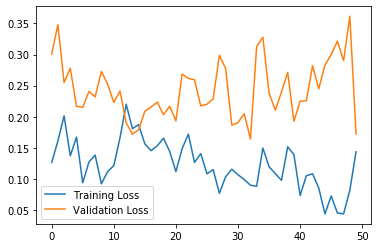

In [32]:
plt.plot(running_loss_history, label='Training Loss')
plt.plot(val_running_loss_history, label='Validation Loss')
plt.legend()

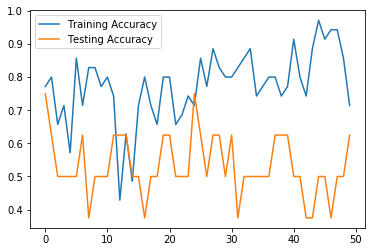

In [33]:
plt.plot(running_corrects_history, label="Training Accuracy")
plt.plot(val_running_corrects_history, label="Testing Accuracy")
plt.legend()

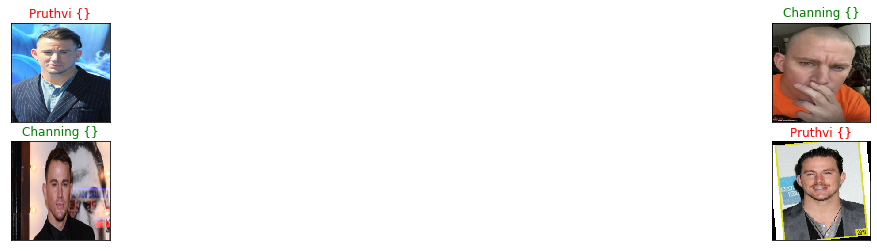

In [43]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()#grabs first batch of training data

images_=images.to(device)
labels=labels.to(device)

output, hidden=model(images_)
_, preds=torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(4):
    ax = fig.add_subplot(2, 2, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))#2 rows and 10 cols and index
    ax.set_title("{} {{}}".format(str(classes[preds[idx].item()]), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))